In [1]:
import tensorflow as tf
tf.test.gpu_device_name()



'/device:GPU:0'

In [0]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl && pip install torchvision
!pip install fastai
!mkdir data & wget http://files.fast.ai/data/dogscats.zip && unzip dogscats.zip -d data/
!pip install Pillow==4.0.0
!pip install PIL
!pip install image


In [0]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch
PATH = "data/dogscats/"
sz=224


In [3]:
import os
os.listdir(PATH)

['test1', 'valid', 'train', 'sample', 'models']

In [4]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [5]:
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.3942.jpg',
 'cat.4535.jpg',
 'cat.4597.jpg',
 'cat.11033.jpg',
 'cat.6610.jpg']

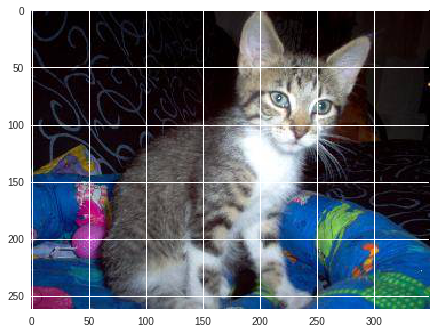

In [6]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [7]:
img.shape

(262, 349, 3)

In [8]:
img[:4,:4]

array([[[18, 17, 33],
        [24, 23, 39],
        [30, 28, 42],
        [26, 22, 36]],

       [[26, 25, 41],
        [27, 26, 40],
        [26, 24, 38],
        [19, 15, 29]],

       [[28, 27, 41],
        [23, 23, 35],
        [16, 14, 27],
        [ 8,  5, 16]],

       [[16, 16, 28],
        [10, 10, 20],
        [ 4,  2, 13],
        [ 1,  0,  7]]], dtype=uint8)

In [10]:
arch=resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy   
    0      0.067803   0.032461   0.987     
    1      0.053749   0.029018   0.991     
 13%|█▎        | 47/360 [00:01<00:11, 26.56it/s, loss=0.0542]    2      0.052937   0.030269   0.988     



[array([0.03027]), 0.988]

In [12]:
data.classes

['cats', 'dogs']

In [13]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [14]:
log_preds[:10]

array([[-0.00016, -8.71426],
       [-0.00058, -7.44657],
       [-0.00058, -7.44826],
       [-0.00065, -7.34342],
       [-0.05873, -2.86403],
       [-0.00303, -5.79927],
       [-0.00207, -6.18221],
       [-0.00037, -7.88949],
       [-0.00005, -9.92623],
       [-0.00011, -9.11023]], dtype=float32)

In [0]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [0]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [0]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [0]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [0]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


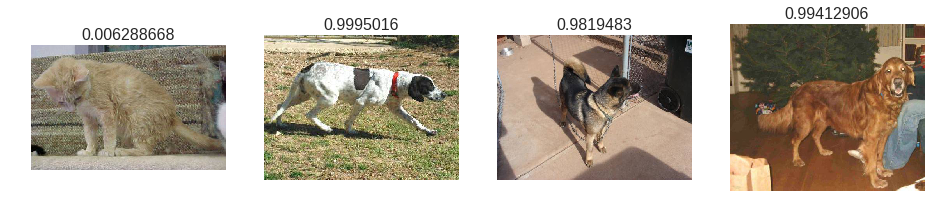

In [21]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


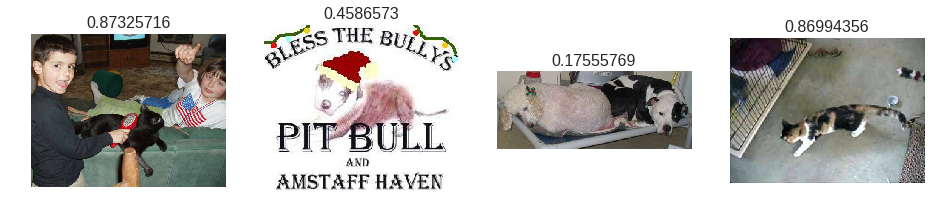

In [22]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

In [0]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


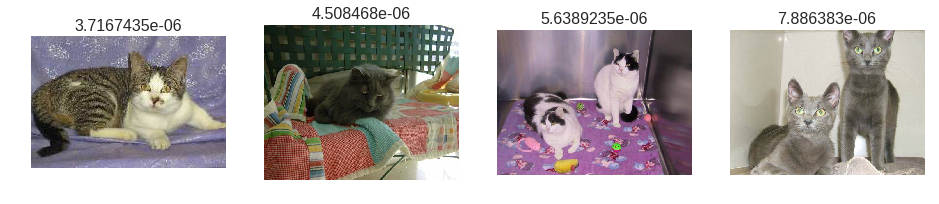

In [24]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


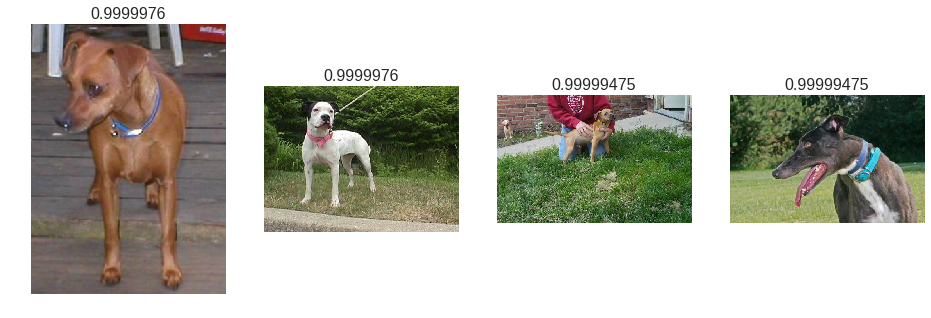

In [25]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect dogs


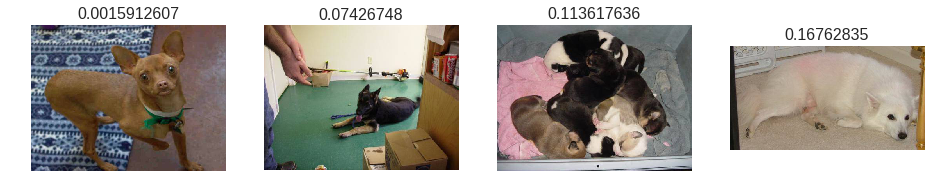

In [26]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


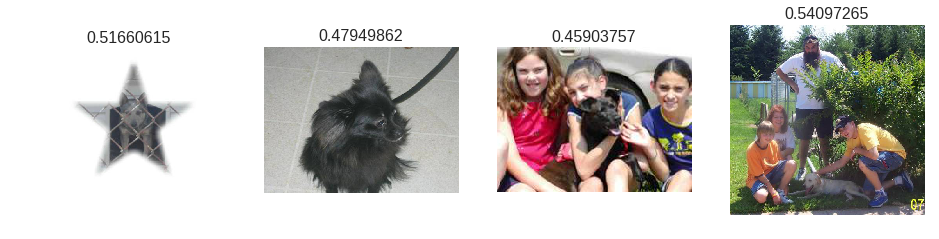

In [27]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")